## 2. Rating Prediction (cont.)

### 2b. Naive Matrix Factorization
This particular implementation uses PyTorch Embeddings to fit a rating matrix.

For all unobserved rating values, including those that are masked out during training, we set them to 0.

The naive MF model is defined in `model.py`, and its loss function is partially adapted from [Google Developer](https://developers.google.com/machine-learning/recommendation/collaborative/matrix). Also, in contrast to Google's optimization, we uses the SGD instead of WALS.

In [1]:
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse

import torch
import torch.nn as nn
import torch.optim as optim

from model import MFNet, custom_loss
import utils as UT

In [2]:
with open("user_ratings.pickle", "rb") as f:
    user_ratings = pickle.load(f)[0]
    
m, n = user_ratings.shape
#bitmask = np.random.rand(m, n) > 0.8
bitmask = UT.generate_bitmask(user_ratings=user_ratings, threshold=0.8)
train = user_ratings.copy()
train[bitmask] = 0

In [3]:
#user_ratings = sparse.csr_matrix(user_ratings)
#train = sparse.csr_matrix(train)

#### i. Training

In [4]:
# set up some training configuration constants
embedding_dim = 5
n_epoch = 15

In [5]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
train_torch = torch.from_numpy(train)
train_torch = train_torch.to(device)

#prox_plus = nn.Threshold(0,0) ## to make all output postive 

model = MFNet(user_count=m, item_count=n, embedding_dim=embedding_dim)
model.to(device)
model.train()

loss_fn = nn.MSELoss(reduction='sum')
losses=[]
optimizer = optim.SGD(model.parameters(), lr=0.000001)

In [6]:
# begin training
start = time.time()

for epoch in range(n_epoch):
    print("epoch:  %d  /  %d"%(epoch+1, n_epoch))
    rows, cols = torch.nonzero(train_torch, as_tuple=True)
    #rows = torch.arange()
    p = np.random.permutation(len(rows))
    rows, cols = rows[p], cols[p]

    for row, col in zip(*(rows, cols)):
        # reset gradient
        optimizer.zero_grad()
        
        # convert rating data to tensor
        rating = torch.FloatTensor([train_torch[row, col]])
        row = torch.LongTensor([row])
        col = torch.LongTensor([col])

        # prediction and loss
        prediction = model(row, col)
        loss = custom_loss(rating, prediction)
        model.zero_grad() # clear used gradients
        loss.backward()
        optimizer.step()
        
        # print(loss)
        losses.append(loss)
    
    lap = time.time()
    avg = (lap-start) / (epoch + 1)
    print("avg time per epoch:  %.2f"%(avg))

epoch:  1  /  15
avg time per epoch:  31.58
epoch:  2  /  15
avg time per epoch:  33.26
epoch:  3  /  15
avg time per epoch:  32.59
epoch:  4  /  15
avg time per epoch:  32.25
epoch:  5  /  15
avg time per epoch:  32.05
epoch:  6  /  15
avg time per epoch:  31.93
epoch:  7  /  15
avg time per epoch:  31.86
epoch:  8  /  15
avg time per epoch:  31.85
epoch:  9  /  15
avg time per epoch:  31.75
epoch:  10  /  15
avg time per epoch:  31.64
epoch:  11  /  15
avg time per epoch:  31.54
epoch:  12  /  15
avg time per epoch:  31.45
epoch:  13  /  15
avg time per epoch:  31.41
epoch:  14  /  15
avg time per epoch:  31.38
epoch:  15  /  15
avg time per epoch:  31.35


Learning Curve


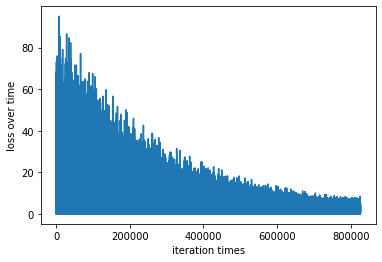


Final Loss
0.7368699908256531


In [7]:
# display loss curve and final loss
print('Learning Curve')
plt.plot(losses)
plt.ylabel('loss over time')
plt.xlabel('iteration times')
plt.show()
print('\nFinal Loss')
print(losses[-1].item())

In [8]:
torch.save(model, "checkpoint.pt")

#### ii. Testing

In [9]:
# test the model
test = np.nonzero(user_ratings - train)
X, Y = test
AEs, SEs = [], []

print("Total test data:",len(X))

model.eval() # eval (crucial line)

for i in range(len(X)):
    x, y = X[i], Y[i]
    xl = torch.LongTensor([x])
    yl = torch.LongTensor([y])

    pred = model(xl, yl).item()
    rating = user_ratings[x, y]
    err = rating - round(pred)

    AEs.append(err)
    SEs.append(np.square(err))

print("Mean Absolute Error (MAE): %.2f"%(sum(AEs) / len(AEs)))
print("Root Mean Square Error (RMSE): %.2f"%(np.sqrt(sum(SEs) / len(SEs))))

Total test data: 176703
Mean Absolute Error (MAE): 1.03
Root Mean Square Error (RMSE): 1.60


#### *continues in* `part3.ipynb`